In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from HW2.benchmark_proceeder import BenchmarkStorage
from HW2.regression_generator import generate_regression
from HW2.sgd import sgd, minibatch_gd, gd
from HW2.visualization import visualize_regression_point, visualize_line, draw_levels
from HW2.optimization import *

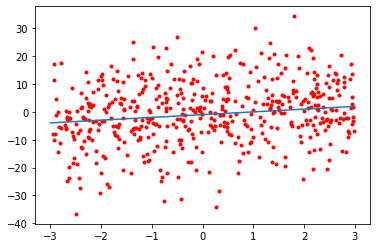

In [2]:
f, points = generate_regression(point_count=500, scale=np.array([3, 10]))

visualize_regression_point(f, points, scale=3)

storage = BenchmarkStorage()

# No optimizations

[ 0.24090657 -0.30160375]
Benchmark results for config <('sgd', 1, Default(no) optimization, Squared error calculator)>:
Mean time:0.326717
Mean memory:0.0B
Mean SMAPE value:0.6174004823419449
Mean RMSE value:8.416932240561906
Mean logcosh value:5.892596727403032
Mean gradient calls:1819.0
Iterations done:1819.0


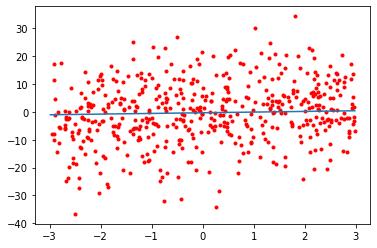

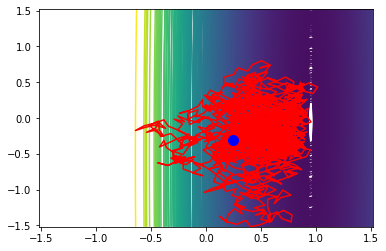

In [3]:
index = storage.add_benchmark_config()
ab, meta = sgd(points)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

# Momentum optimization

[0.11452023 0.25557121]
Benchmark results for config <('sgd', 1, Momentum optimization (beta=0.95), Squared error calculator)>:
Mean time:0.007519
Mean memory:0.0B
Mean SMAPE value:0.7743377232659371
Mean RMSE value:9.883922584371849
Mean logcosh value:7.021864985010164
Mean gradient calls:50.0
Iterations done:50.0


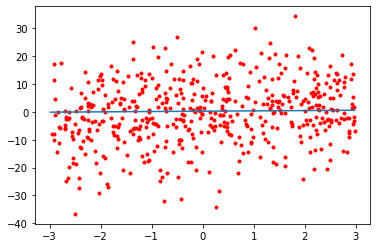

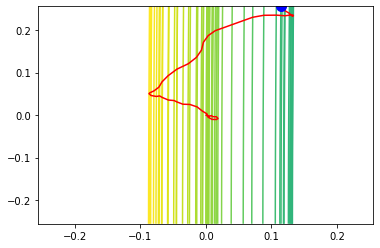

In [4]:
optimization = MomentumOptimization(beta=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Функция стала более сглаженной из-за бегущего среднего по градиентам и происходит некая "имитация" `Minibatch GD`

# Nesterov optimization

[0.54668214 0.03545544]
Benchmark results for config <('sgd', 1, Nesterov optimization (beta=0.95), Squared error calculator)>:
Mean time:0.014613
Mean memory:0.0B
Mean SMAPE value:0.3425563714085009
Mean RMSE value:4.974878324751744
Mean logcosh value:3.2486839841571453
Mean gradient calls:55.0
Iterations done:55.0


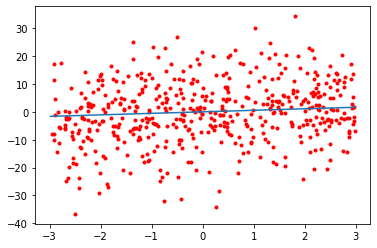


KeyboardInterrupt



In [5]:
optimization = NesterovOptimization(beta=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Также, так и в `Momentum`, есть бегущее среднее по градиентам, что делает функцию более гладкой
* Но сходимся мы лучше т.к. берем градиент от точки бегущего среднего, а не от изначальной

# AdaGrad optimization

In [ ]:
optimization = AdaGradOptimization()
ab, meta = sgd(points, optimization=optimization, eps=5e-3)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
index = storage.add_benchmark_config(optimiser=optimization)
draw_levels(points, meta["points"])

#### Наблюдения

* Шаги делаем не такие широкие, так как берем сумму квадратов градиентов и делим на `lr`
* Из-за этого уменьшаем `eps` $\Rightarrow$ увеличивается точность схождения
* Из-за этого же есть затухание градиента, что хорошо для некоторого типа задач

# RMSProp optimization

In [ ]:
optimization = RMSPropOptimization(gamma=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization, lr=0.01, eps=1e-2)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

In [ ]:
optimization = RMSPropOptimization(gamma=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization, lr=0.01, eps=1e-2)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Как и в предыдущем методе, мы накапливаем сумму квадратов градиента, но у же бегущее среднее по ним
* А значит функция становится более гладкой
* Это позволяет более точно идти в нужном направлении
* И как следствие -- гораздо дальше (`eps` уменьшаем)

# Adam optimization

In [ ]:
optimization = AdamOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

In [ ]:
optimization = AdamOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* `Adam` является объединением всех вышеупомянутых идей
* Это позволяет ему сходиться гораздо точнее и гораздо быстрее

# Benchmark

In [ ]:
optimizators = [DefaultOptimization(), MomentumOptimization(0.95), NesterovOptimization(0.95), AdaGradOptimization(),
                RMSPropOptimization(0.5), AdamOptimization()]

result = np.array([])
for optimization in tqdm(optimizators, "Optimization"):
    index = storage.add_benchmark_config(optimiser=optimization)
    for _ in range(20):
        ab, meta = minibatch_gd(points, optimization=optimization)
        storage.add_benchmark_result(index, meta)
    result = np.append(result, storage.get_benchmark_results_arrayed(index))

result = result.reshape((-1, 8))
df = pd.DataFrame(result, columns=[
    'Config',
    'Mean time',
    'Mean mem',
    'Mean SMAPE',
    'Mean RMSE',
    'Mean logcosh',
    'Mean gradient calls',
    'Mean iterations'
])
df.to_csv("data/2.3.csv", sep='\t')
df